## Import necessary libraries

In [1]:
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as img
import pandas as pd
import torch
import time

## Data

In [2]:
training = r"VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\train"
testing = r"VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\test"
validation = r"VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\valid"

In [3]:
train_csv_path = Path("train\_classes.csv")
train_data = pd.read_csv(train_csv_path)

test_csv_path = Path("test\_classes.csv")
test_data = pd.read_csv(test_csv_path)

valid_csv_path = Path("valid\_classes.csv")
valid_data = pd.read_csv(valid_csv_path)

train_data

,filename,crack,normal,scratch,stain
0,_MG_2319_jpg.rf.860aa871d3d1e461ee971df521cdf3...,0,0,1,0
1,_MG_3117_jpg.rf.860df5dd592ee8c927e1270cd1f3d0...,1,0,1,1
2,images-42-_jpeg.rf.8644f779e0cd1c5b8a5912ed4b0...,0,1,0,0
3,_MG_2319_jpg.rf.8691912fbcd8a14d00763065ea1e7b...,0,0,1,0
4,_MG_2297_jpg.rf.86d6414b9696a8b08dc785c038e1f9...,0,0,1,0
...,...,...,...,...,...
3172,147-Q4-A_jpg.rf.85ae7bef0ec58a9965b778dd1c2c3b...,0,1,0,0
3173,_MG_2810_jpg.rf.84b43da13bfa88ec4472bb81a69c0f...,0,0,1,0
3174,_MG_3174_jpg.rf.85b00e8ccf11556853d36562fd7d77...,0,0,1,1
3175,_MG_2652_jpg.rf.85042fd84f98fbe2cb0790ba275137...,0,0,1,1


In [4]:
# Associate file paths with their labels
train_data['image_path'] = train_data['filename'].apply(lambda x: str(Path(r"C:\Users\spenc\projects\Ceramic Tiles Defect Classification [PROJECT DESIGN]\VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\train") / x))
test_data['image_path'] = test_data['filename'].apply(lambda x: str(Path(r"C:\Users\spenc\projects\Ceramic Tiles Defect Classification [PROJECT DESIGN]\VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\test") / x))
valid_data['image_path'] = valid_data['filename'].apply(lambda x: str(Path(r"C:\Users\spenc\projects\Ceramic Tiles Defect Classification [PROJECT DESIGN]\VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\valid") / x))

In [5]:
def one_hot_labels(row):
    return torch.tensor([row['crack'], row['normal'], row['scratch'], row['stain']], dtype=torch.float32)

train_data['labels'] = train_data.apply(one_hot_labels, axis=1)
test_data['labels']= test_data.apply(one_hot_labels, axis=1)
valid_data['labels']= valid_data.apply(one_hot_labels, axis=1)

In [6]:
train_data

,filename,crack,normal,scratch,stain,image_path,labels
0,_MG_2319_jpg.rf.860aa871d3d1e461ee971df521cdf3...,0,0,1,0,C:\Users\spenc\projects\Ceramic Tiles Defect C...,"[tensor(0.), tensor(0.), tensor(1.), tensor(0.)]"
1,_MG_3117_jpg.rf.860df5dd592ee8c927e1270cd1f3d0...,1,0,1,1,C:\Users\spenc\projects\Ceramic Tiles Defect C...,"[tensor(1.), tensor(0.), tensor(1.), tensor(1.)]"
2,images-42-_jpeg.rf.8644f779e0cd1c5b8a5912ed4b0...,0,1,0,0,C:\Users\spenc\projects\Ceramic Tiles Defect C...,"[tensor(0.), tensor(1.), tensor(0.), tensor(0.)]"
3,_MG_2319_jpg.rf.8691912fbcd8a14d00763065ea1e7b...,0,0,1,0,C:\Users\spenc\projects\Ceramic Tiles Defect C...,"[tensor(0.), tensor(0.), tensor(1.), tensor(0.)]"
4,_MG_2297_jpg.rf.86d6414b9696a8b08dc785c038e1f9...,0,0,1,0,C:\Users\spenc\projects\Ceramic Tiles Defect C...,"[tensor(0.), tensor(0.), tensor(1.), tensor(0.)]"
...,...,...,...,...,...,...,...
3172,147-Q4-A_jpg.rf.85ae7bef0ec58a9965b778dd1c2c3b...,0,1,0,0,C:\Users\spenc\projects\Ceramic Tiles Defect C...,"[tensor(0.), tensor(1.), tensor(0.), tensor(0.)]"
3173,_MG_2810_jpg.rf.84b43da13bfa88ec4472bb81a69c0f...,0,0,1,0,C:\Users\spenc\projects\Ceramic Tiles Defect C...,"[tensor(0.), tensor(0.), tensor(1.), tensor(0.)]"
3174,_MG_3174_jpg.rf.85b00e8ccf11556853d36562fd7d77...,0,0,1,1,C:\Users\spenc\projects\Ceramic Tiles Defect C...,"[tensor(0.), tensor(0.), tensor(1.), tensor(1.)]"
3175,_MG_2652_jpg.rf.85042fd84f98fbe2cb0790ba275137...,0,0,1,1,C:\Users\spenc\projects\Ceramic Tiles Defect C...,"[tensor(0.), tensor(0.), tensor(1.), tensor(1.)]"


### Inception transform

In [7]:
in_train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
])

in_test_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
])

in_valid_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
])


### Resnet transform

In [8]:
res_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
])

res_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
])

res_valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
])


In [9]:
class TileDefectDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.dataframe.iloc[idx]['image_path']
        labels = self.dataframe.iloc[idx]['labels']

        # Open image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        return image, labels

## Create DataLoaders

In [33]:
# Training dataset
train_dataset = TileDefectDataset(train_data, transform= res_train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation and test datasets (similar approach)
test_dataset = TileDefectDataset(test_data, transform=in_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

valid_dataset = TileDefectDataset(valid_data, transform=res_valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [37]:
for inputs, labels in test_loader:
    print(inputs.shape)  # Shape of input images
    print(labels.shape)  # Shape of labels
    break


torch.Size([32, 3, 299, 299])
torch.Size([32, 4])


## Define CNN model

### VGG Model

In [12]:
def create_vgg_model(num_classes):
    vgg_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)  # pre-trained
    vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, num_classes)

    # Freeze convolutional layers 
    for param in vgg_model.features.parameters():
        param.requires_grad = False
        
    return vgg_model

### Inception Model

In [40]:
def create_inception_model(num_classes):
    inception_model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)  # pre-trained
    num_features = inception_model.fc.in_features
    inception_model.fc = nn.Sequential( # Modify final layer based on number of classes 
        nn.Linear(num_features,  num_classes)
    )
    inception_model.aux_logits = True
    if inception_model.aux_logits:
        num_aux_features = inception_model.AuxLogits.fc.in_features
        inception_model.AuxLogits.fc = nn.Linear(num_aux_features, num_classes)

    # Freeze convolutional layers
    for name, param in inception_model.named_parameters():
        if 'fc' not in name and 'AuxLogits' not in name:
            param.requires_grad = False

    return inception_model

### ResNet Model

In [14]:
def create_resnet_model(num_classes):
    resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # pre-trained
    num_features = resnet_model.fc.in_features
    resnet_model.fc = nn.Sequential(
        nn.Linear(num_features, num_classes)
    )

    # Freeze layers
    for name, param in resnet_model.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False
            
    return resnet_model

In [15]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

## Training functions

In [16]:
def train_vgg16_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    """
    Training function for VGG16 model.
    
    Parameters:
        model: The VGG16 model to train.
        train_loader: DataLoader for training dataset.
        val_loader: DataLoader for validation dataset.
        criterion: Loss function (e.g., BCEWithLogitsLoss).
        optimizer: Optimizer (e.g., Adam).
        epochs: Number of epochs to train.
        device: Device to train on (CPU or GPU).
    
    Returns:
        train_losses, train_accuracies, val_losses, val_accuracies
    """
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Progress update every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")
            # Accumulate metrics
            running_loss += loss.item()
            sigmoid_outputs = torch.sigmoid(outputs)
            preds = (sigmoid_outputs > 0.5).float()  # Threshold for binary classification
            correct += (preds == labels).sum().item()
            total += labels.numel()

        # Calculate epoch metrics for training
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation Loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate metrics
                val_loss += loss.item()
                sigmoid_outputs = torch.sigmoid(outputs)
                preds = (sigmoid_outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()

        # Calculate epoch metrics for validation
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [17]:
def train_resnet_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # patience = 5
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)   # error

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            sigmoid_outputs = torch.sigmoid(outputs)
            preds = (sigmoid_outputs > 0.3).float()  # For classification
            correct += (preds == labels).sum().item()  # Correct if all labels match
            total += labels.numel()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                if batch_idx % 10 == 0:
                    print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")
                sigmoid_outputs = torch.sigmoid(outputs)
                preds = (sigmoid_outputs > 0.3).float()
                val_correct += (preds == labels).sum().item()  # Correct if all labels match
                val_total += labels.numel()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [18]:
def train_inception_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            optimizer.zero_grad()

            # Forward pass (handle auxiliary outputs)
            outputs = model(inputs)
            if isinstance(outputs, tuple):  # Handle auxiliary classifier output
                main_output, aux_output = outputs
                loss = criterion(main_output, labels) + 0.4 * criterion(aux_output, labels)
                outputs = main_output
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 4)    # clip gradients to stabilize updates
            optimizer.step()
            running_loss += loss.item()

            # Progress update every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")
                
            sigmoid_outputs = torch.sigmoid(outputs)
            preds = (sigmoid_outputs > 0.3).float()  # For classification
            correct += (preds == labels).sum().item()
            total += labels.numel()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)

                if isinstance(outputs, tuple):  # Only use main output for validation
                    outputs = outputs[0]

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                sigmoid_outputs = torch.sigmoid(outputs)
                preds = (sigmoid_outputs > 0.3).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


## Model evaluation function

In [19]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            sigmoid_outputs = torch.sigmoid(outputs)
            test_loss += loss.item()
            preds = (sigmoid_outputs > 0.3).float() 
            correct += (preds == labels).sum().item()  # Correct if all labels match
            total += labels.numel()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy


## Model training

### VGG16 training

In [20]:
# Create model
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model = create_vgg_model(num_classes)

vgg_model.to(device)  # move to GPU

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Save timestamp
start = time.time()

# Training the model
train_losses, train_accuracies, val_losses, val_accuracies = train_vgg16_model(
    model=vgg_model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10,
    device=device
)

end = time.time()
print(f'Training time duration: {end - start}')

Epoch 1, Batch 0/100: Loss 0.6816
Epoch 1, Batch 10/100: Loss 0.3110
Epoch 1, Batch 20/100: Loss 0.1424
Epoch 1, Batch 30/100: Loss 0.1322
Epoch 1, Batch 40/100: Loss 0.1163
Epoch 1, Batch 50/100: Loss 0.1410
Epoch 1, Batch 60/100: Loss 0.1294
Epoch 1, Batch 70/100: Loss 0.1049
Epoch 1, Batch 80/100: Loss 0.1244
Epoch 1, Batch 90/100: Loss 0.0831
Epoch 1/10 - Train Loss: 0.1968, Train Acc: 0.9162, Val Loss: 0.1364, Val Acc: 0.9422
Epoch 2, Batch 0/100: Loss 0.0920
Epoch 2, Batch 10/100: Loss 0.1284
Epoch 2, Batch 20/100: Loss 0.2003
Epoch 2, Batch 30/100: Loss 0.0900
Epoch 2, Batch 40/100: Loss 0.1233
Epoch 2, Batch 50/100: Loss 0.1287
Epoch 2, Batch 60/100: Loss 0.1106
Epoch 2, Batch 70/100: Loss 0.0587
Epoch 2, Batch 80/100: Loss 0.1673
Epoch 2, Batch 90/100: Loss 0.0572
Epoch 2/10 - Train Loss: 0.1237, Train Acc: 0.9492, Val Loss: 0.1327, Val Acc: 0.9480
Epoch 3, Batch 0/100: Loss 0.0521
Epoch 3, Batch 10/100: Loss 0.0325
Epoch 3, Batch 20/100: Loss 0.1663
Epoch 3, Batch 30/100: Los

### Inception training

In [22]:
# Create model
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = create_inception_model(num_classes)
inception_model.aux_logits = True  # Enable auxiliary outputs for training
inception_model.to(device)  # move to GPU

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(inception_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Save timestamp
start = time.time()

# Training the model
train_losses, train_accuracies, val_losses, val_accuracies = train_inception_model(
    model=inception_model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10,
    device=device
)

end = time.time()
print(f'Training time duration: {end - start}')

Epoch 1, Batch 0/100: Loss 1.0122
Epoch 1, Batch 10/100: Loss 0.7949
Epoch 1, Batch 20/100: Loss 0.7292
Epoch 1, Batch 30/100: Loss 0.6647
Epoch 1, Batch 40/100: Loss 0.6259
Epoch 1, Batch 50/100: Loss 0.7133
Epoch 1, Batch 60/100: Loss 0.5683
Epoch 1, Batch 70/100: Loss 0.5121
Epoch 1, Batch 80/100: Loss 0.5820
Epoch 1, Batch 90/100: Loss 0.6218
Epoch 1/10 - Train Loss: 0.6628, Train Acc: 0.5840, Val Loss: 0.4822, Val Acc: 0.7376
Epoch 2, Batch 0/100: Loss 0.5627
Epoch 2, Batch 10/100: Loss 0.5713
Epoch 2, Batch 20/100: Loss 0.5152
Epoch 2, Batch 30/100: Loss 0.4814
Epoch 2, Batch 40/100: Loss 0.4921
Epoch 2, Batch 50/100: Loss 0.5426
Epoch 2, Batch 60/100: Loss 0.4439
Epoch 2, Batch 70/100: Loss 0.4308
Epoch 2, Batch 80/100: Loss 0.4679
Epoch 2, Batch 90/100: Loss 0.4679
Epoch 2/10 - Train Loss: 0.5072, Train Acc: 0.7712, Val Loss: 0.3956, Val Acc: 0.8350
Epoch 3, Batch 0/100: Loss 0.5159
Epoch 3, Batch 10/100: Loss 0.4481
Epoch 3, Batch 20/100: Loss 0.4994
Epoch 3, Batch 30/100: Los

### ResNet training

In [43]:
# Create model
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = create_resnet_model(num_classes)
resnet_model = resnet_model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4, weight_decay=1e-5)

start = time.time()
# Training the model
train_losses, train_accuracies, val_losses, val_accuracies = train_resnet_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10,
    device=device
)
end = time.time()
print(f"Resnet model training time: {end - start}")

Epoch 1/10 - Train Loss: 0.5608, Train Acc: 0.6040, Val Loss: 0.4801, Val Acc: 0.7228
Epoch 2/10 - Train Loss: 0.4407, Train Acc: 0.7768, Val Loss: 0.3775, Val Acc: 0.8523
Epoch 3/10 - Train Loss: 0.3752, Train Acc: 0.8439, Val Loss: 0.3249, Val Acc: 0.8845
Epoch 4/10 - Train Loss: 0.3323, Train Acc: 0.8672, Val Loss: 0.2903, Val Acc: 0.8977
Epoch 5/10 - Train Loss: 0.3029, Train Acc: 0.8813, Val Loss: 0.2645, Val Acc: 0.9018
Epoch 6/10 - Train Loss: 0.2836, Train Acc: 0.8931, Val Loss: 0.2505, Val Acc: 0.9092
Epoch 7/10 - Train Loss: 0.2666, Train Acc: 0.8990, Val Loss: 0.2340, Val Acc: 0.9117
Epoch 8/10 - Train Loss: 0.2539, Train Acc: 0.9021, Val Loss: 0.2228, Val Acc: 0.9150
Epoch 9/10 - Train Loss: 0.2416, Train Acc: 0.9064, Val Loss: 0.2141, Val Acc: 0.9167
Epoch 10/10 - Train Loss: 0.2377, Train Acc: 0.9060, Val Loss: 0.2109, Val Acc: 0.9200
Resnet model training time: 64.74277400970459


### Results of training

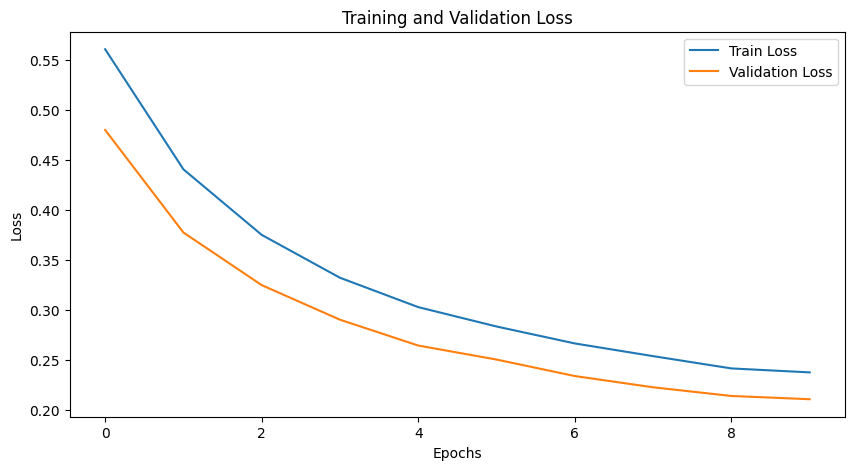

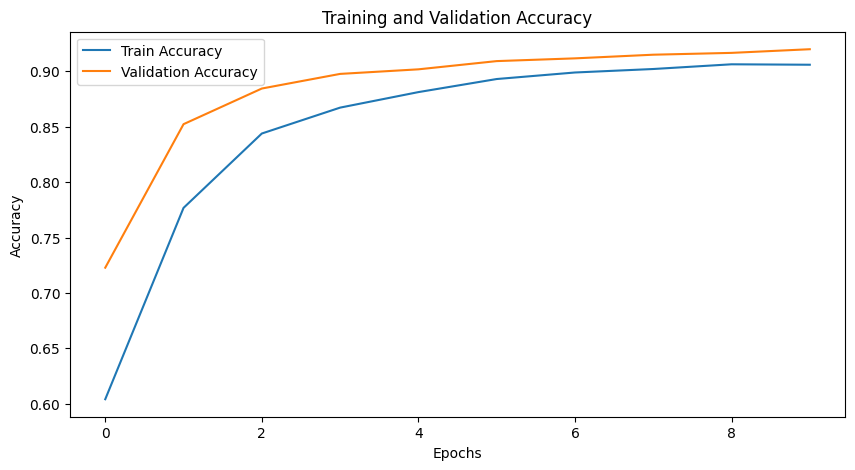

In [44]:
# Evaluating the model on the test set
# test_loss, test_accuracy = evaluate_model(
#     model=resnet_model,
#     test_loader=test_loader,
#     criterion=criterion,
#     device=device


# Visualize results
# Visualize training and validation performance

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('Resnet18 - Training and Validation Loss')
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('Resnet18 - Training and Validation Accuracy')
plt.show()

### Save Model

In [ ]:
# save VGG model
PATH = r"CNNmodels\vgg_weights.pt"
torch.save(vgg_model.state_dict(), PATH)

In [24]:
# save inception model
PATH = r"CNNmodels\inception_weights.pt"
torch.save(inception_model.state_dict(), PATH)

In [45]:
PATH = r"CNNmodels\resnet_weights.pt"
torch.save(resnet_model.state_dict(), PATH)

### Test for unknown data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].


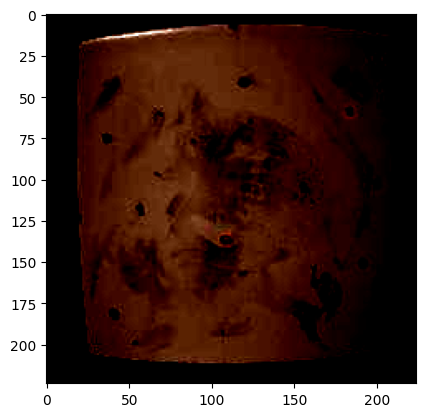

Correct labels: [0 0 1]
Raw predicted scores: [[ -4.238361 -13.837447  11.55397 ]]
Sigmoid probabilities: [[1.4225928e-02 9.7830139e-07 9.9999034e-01]]
Binary predicted labels: [[0 0 1]]


In [53]:
input, label = test_dataset[0]

# Convert tensor to numpy array 
image = input.numpy().transpose((1,2,0))[:, :, ::-1]

# Display image
plt.imshow(image)
plt.show()

# Start predicting
resnet_model.eval()
input = input.to(device) # move inputs to gpu
# Forward pass
with torch.no_grad():
    predicted = resnet_model(input.unsqueeze(0))
    sigmoid_predicted = torch.sigmoid(predicted)
    binary_predicted = (sigmoid_predicted > 0.3).int() # Threshold

predicted = predicted.cpu().numpy() # remove from computational graph to cpu and as numpy
sigmoid_predicted = sigmoid_predicted.cpu().numpy()
binary_predicted = binary_predicted.cpu().numpy()

#  Display results
print(f"Correct labels: {label.numpy()}")  # Convert label tensor to numpy for consistency
print(f"Raw predicted scores: {predicted}")
print(f"Sigmoid probabilities: {sigmoid_predicted}")
print(f"Binary predicted labels: {binary_predicted}")

## Transform image to model readable format


In [27]:
def preprocess_image(image_path):
    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
    ])
    image = Image.open(image_path).convert('RGB')
    preprocessed_image = preprocess(image)
    return preprocessed_image

def predict_image(model, preprocessed_input, device):
    model.eval()
    with torch.no_grad():
        preprocessed_input = preprocessed_input.to(device)
        output = model(preprocessed_input.unsqueeze(0))
        sigmoid_output = torch.sigmoid(output)
        binary_output = (sigmoid_output > 0.3).int()
        binary_output = binary_output.cpu().numpy()
        return binary_output

def convert_output_to_string(output, class_labels):
    for i in np.ptp(output):
        print(i)

from sklearn.metrics import precision_score
import torch

def evaluate_precision(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5  # Apply threshold for multi-label
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute Precision (average='weighted' accounts for class imbalance)
    precision = precision_score(all_labels, all_preds, average='weighted')
    return float(precision * 100)

## Evaluate model precision

In [29]:
# Load Resnet
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = r"CNNmodels\resnet_weights.pt"

resnet_model = create_resnet_model(num_classes)
resnet_model.to(device)
resnet_model.load_state_dict(torch.load(PATH, weights_only=True))

# Get precision on test loader (unknown data)
precision_resnet = evaluate_precision(resnet_model, test_loader, device)
precision_resnet

88.67725281602003

In [30]:
# Load VGG
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = r"CNNmodels\vgg_weights.pt"

vgg_model = create_vgg_model(num_classes)
vgg_model.to(device)
vgg_model.load_state_dict(torch.load(PATH, weights_only=True))

# Get precision on test loader (unknown data)
precision_vgg = evaluate_precision(vgg_model, test_loader, device)
precision_vgg

93.724971395881

In [41]:
# Load Inception
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = r"CNNmodels\inception_weights.pt"

inception_model = create_inception_model(num_classes)
inception_model.to(device)
inception_model.load_state_dict(torch.load(PATH, weights_only=True))

# Get precision on test loader (unknown data)
precision_inception = evaluate_precision(inception_model, test_loader, device)
precision_inception

92.48681419880562

## Get average inference time per model

In [42]:
def measure_inference_time(model, test_loader, device, num_batches=20):
    """
    Measures the average inference time of a model.

    Args:
        model (torch.nn.Module): The PyTorch model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): The device to run the inference on (e.g., "cuda" or "cpu").
        num_batches (int): The number of batches to use for timing inference.

    Returns:
        float: The average inference time per image (in milliseconds).
    """
    model.eval()  # Set the model to evaluation mode
    total_time = 0.0  # Total time for all inferences
    total_images = 0  # Total number of images processed

    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (inputs, _) in enumerate(test_loader):
            if batch_idx >= num_batches:
                break  # Stop after processing the specified number of batches
            
            inputs = inputs.to(device)
            batch_size = inputs.size(0)

            start_time = time.time()  # Start timing
            outputs = model(inputs)  # Perform inference
            end_time = time.time()  # End timing

            batch_time = end_time - start_time  # Time for this batch
            total_time += batch_time
            total_images += batch_size

    # Compute the average inference time per image
    avg_time_per_image = (total_time / total_images) * 1000  # Convert to milliseconds
    return avg_time_per_image

In [52]:
# Design 1: Resnet
resnet_avg_inference = measure_inference_time(resnet_model, test_loader, device)
print(f"ResNet average inference time: {resnet_avg_inference} milliseconds")

ResNet average inference time: 0.13639279548695546 milliseconds


In [50]:
# Design 2: VGG
vgg_avg_inference = measure_inference_time(vgg_model, test_loader, device)
print(f"VGG average inference time: {vgg_avg_inference} milliseconds")

VGG average inference time: 0.08986643608042735 milliseconds


In [48]:
# Design 3: Inception
inception_avg_inference = measure_inference_time(inception_model, test_loader, device)
print(f"Inception average inference time: {inception_avg_inference} milliseconds")

Inception average inference time: 0.6812803003172211 milliseconds


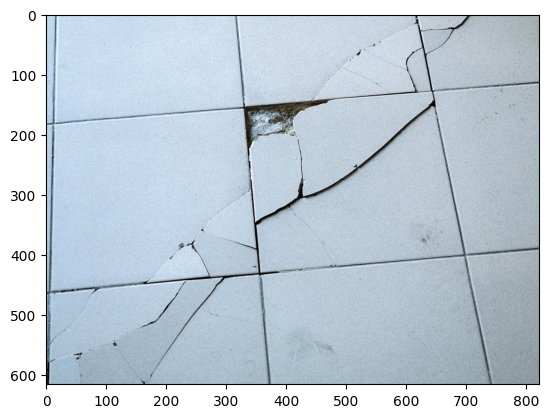

In [7]:
# Predict unknown data
test_img_path = r"crack_tiles.png"
testImage = img.imread(test_img_path)
plt.imshow(testImage)
p_input = preprocess_image(test_img_path)

In [8]:
c_labels = ['Crack', 'Scratch', 'Stain']
output = (predict_image(resnet_model, preprocessed_input=p_input, device=device))
print(output)

[[1 0 1]]
